In [1]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [2]:
import os
import glob
import datetime
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
TRAIN_DIR = '/kaggle/input/covid-19-x-rays-images/train/'
VAL_DIR = '/kaggle/input/covid-19-x-rays-images/val/'
TEST_DIR = '/kaggle/input/covid-19-x-rays-images/test/'

In [ ]:
non_covid = glob.glob(f"{os.path.join(TRAIN_DIR, '0')}/*.png")[:4]
covid =  glob.glob(f"{os.path.join(TRAIN_DIR, '1')}/*.png")[:4]

### Non-Covid Images

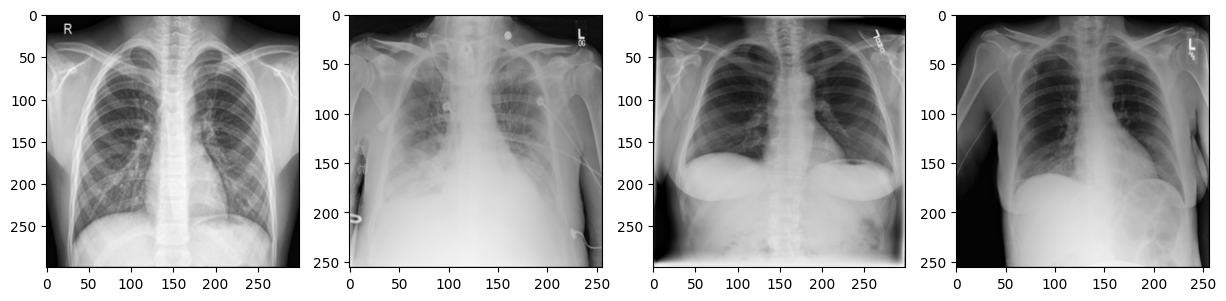

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(non_covid[i])
    ax[i].imshow(img)

### Covid Images

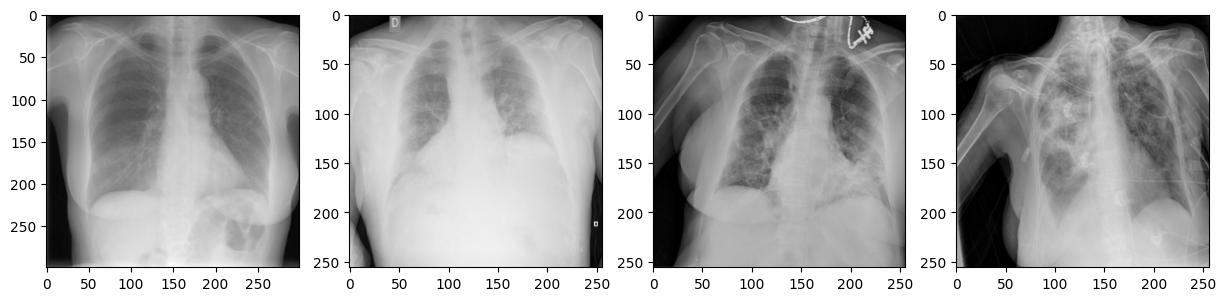

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(covid[i])
    ax[i].imshow(img)

### Parameters

In [3]:
# Initialize
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
TARGET_SIZE = (299, 299)

### Data Augmentation

In [ ]:
# create data generators with image augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='binary'
                                                   )

Found 7000 images belonging to 2 classes.


In [ ]:
# create data generators with image augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255.0)

val_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


## Build the model

In [ ]:
def build_model():
    # load Xception model and ensuring the head FC layer sets are left off.
    base_model = tf.keras.applications.Xception(weights="imagenet",
                                          include_top=False,
                                          input_shape=(299,299, 3))

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # construct the head of the model that will be placed on top the above of base model
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
#     model.add(tf.keras.layers.Dense(1024, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
def tune_learning_rate(model):

  # set learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10 ** (epoch/10))

  # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='binary_crossentropy',
          metrics=['accuracy'])

    history = model.fit(train_generator,
                        epochs=100,
                        callbacks=[lr_schedule])

    return history

In [ ]:
# build the model
model_tune = build_model()
lr_history = tune_learning_rate(model_tune)

83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/100
110/110 [==============================] - 252s 2s/step - loss: 0.7090 - accuracy: 0.4930 - lr: 1.0000e-08
Epoch 2/100
110/110 [==============================] - 190s 2s/step - loss: 0.7058 - accuracy: 0.4974 - lr: 1.2589e-08
Epoch 3/100
110/110 [==============================] - 189s 2s/step - loss: 0.7060 - accuracy: 0.4997 - lr: 1.5849e-08
Epoch 4/100
110/110 [==============================] - 189s 2s/step - loss: 0.7044 - accuracy: 0.4997 - lr: 1.9953e-08
Epoch 5/100
110/110 [==============================] - 190s 2s/step - loss: 0.7047 - accuracy: 0.5001 - lr: 2.5119e-08
Epoch 6/100
110/110 [==============================] - 190s 2s/step - loss: 0.7052 - accuracy: 0.4967 - lr: 3.1623e-08
Epoch 7/100
110/110 [==============================] - 190s 2s/step - loss: 0.7013 - accuracy: 0.5081 - lr: 3.9811e-08
Epoch 8/100
110/110 [==============================] - 189s 2s/step - loss: 0.7023 - accuracy: 0.5086 

In [ ]:
def plot_learning_rate(history):
    plt.figure(figsize=(10,6))
    plt.semilogx(history.history['lr'][15:80], history.history['loss'][15:80])
    plt.tick_params('both', length=10, width=1, which='both')

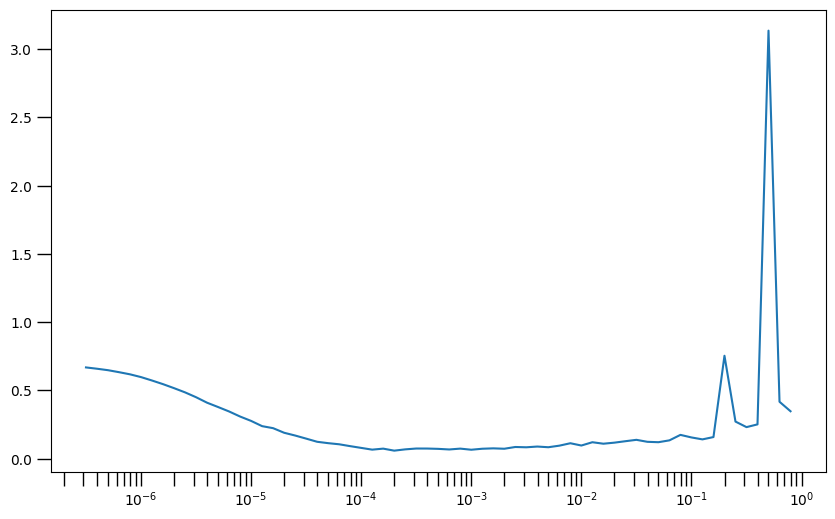

In [ ]:
plot_learning_rate(lr_history)

In [39]:
# set the updated learning rate
LR = 4e-4

## Train and compile the model

In [ ]:
def compile_model(model):
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
      loss='binary_crossentropy',
      metrics=['accuracy'])

    # define callbacks
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=5,
                                             verbose=1,
                                             mode='max',
                                             restore_best_weights=True)

    # Fit the model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=30,
                        callbacks=earlystop)

    return history

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 12,170,353
Non-trainable params: 8,693,176
_________________________________________________________________


In [ ]:
model = build_model()
history = compile_model(model)

Epoch 1/30
110/110 [==============================] - 236s 2s/step - loss: 0.2696 - accuracy: 0.8851 - val_loss: 0.2719 - val_accuracy: 0.8987
Epoch 2/30
110/110 [==============================] - 194s 2s/step - loss: 0.1369 - accuracy: 0.9500 - val_loss: 0.1081 - val_accuracy: 0.9613
Epoch 3/30
110/110 [==============================] - 193s 2s/step - loss: 0.1077 - accuracy: 0.9584 - val_loss: 0.0909 - val_accuracy: 0.9693
Epoch 4/30
110/110 [==============================] - 192s 2s/step - loss: 0.0805 - accuracy: 0.9679 - val_loss: 0.1126 - val_accuracy: 0.9573
Epoch 5/30
110/110 [==============================] - 216s 2s/step - loss: 0.0668 - accuracy: 0.9744 - val_loss: 0.1296 - val_accuracy: 0.9560
Epoch 6/30
110/110 [==============================] - 208s 2s/step - loss: 0.0608 - accuracy: 0.9777 - val_loss: 0.1153 - val_accuracy: 0.9593
Epoch 7/30
110/110 [==============================] - 207s 2s/step - loss: 0.0555 - accuracy: 0.9790 - val_loss: 0.1160 - val_accuracy: 0.9593

## Model Evaluation

In [ ]:
def plot(history, string, y):
    plt.plot(history.history[string], label='training')
    plt.plot(history.history[f'val_{string}'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.ylim(y)
    plt.title(f'model {string}')
    plt.legend(loc='upper left')
    plt.savefig(f"/kaggle/working/models/model_{string}.png");

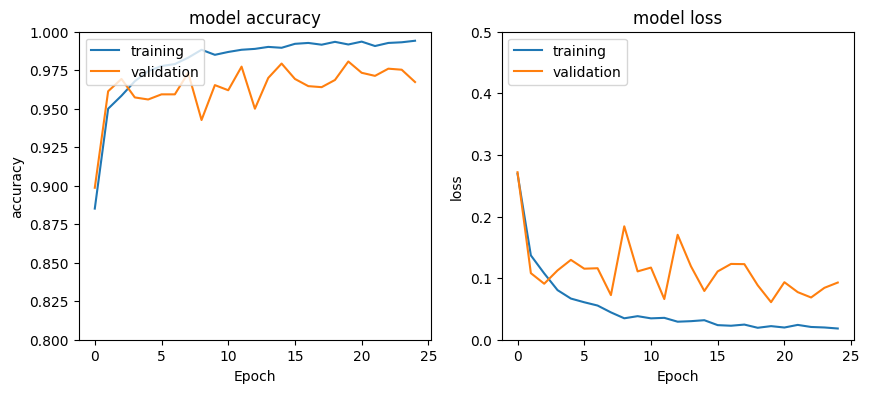

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plot(history, 'accuracy', y=(0.8, 1.0))
plt.subplot(1,2,2)
plot(history, 'loss', y=(0, 0.5))

## Save Model

In [ ]:
timestamp = datetime.date.today()
file_path = os.path.join('/kaggle/working/models', f'{str(timestamp)}_xception.h5')
model.save(file_path)

## Inference

In [ ]:
model = tf.keras.models.load_model('/kaggle/working/models/2023-09-15_xception.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


In [ ]:
predicted = model.predict(test_generator, verbose=1)

24/24 [==============================] - 17s 699ms/step


In [ ]:
predicted.shape

(1500, 1)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy, 4)}")

24/24 [==============================] - 11s 418ms/step - loss: 0.0707 - accuracy: 0.9753

Test Loss: 0.0707
Test Accuracy: 0.9753


In [ ]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
predicted_classes = np.round(predicted)
predicted_classes

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

### Confusion Matrix

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
cm

array([[731,  19],
       [ 18, 732]])

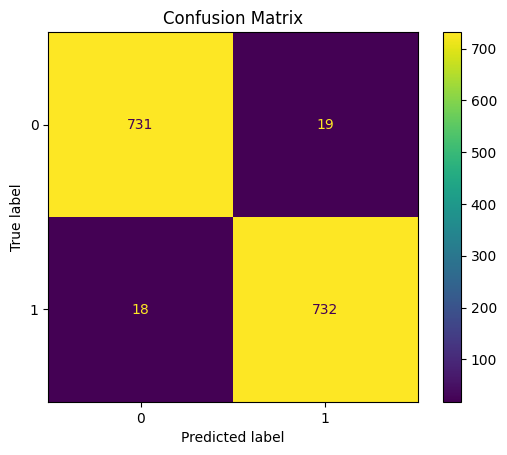

In [ ]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()
plt.title("Confusion Matrix")
plt.savefig("/kaggle/working/models/confusion_matrix.png");

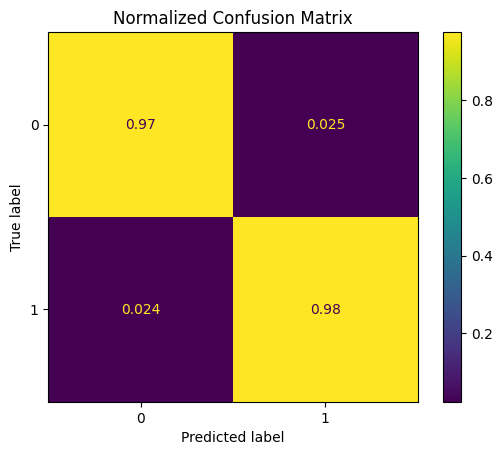

In [ ]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)

# plot the normalized confusion matrix
cm_display.plot()
plt.title("Normalized Confusion Matrix")
plt.savefig("/kaggle/working/models/normalized_confusion_matrix.png");

## Test with the new datasets

In [67]:
%cd /content/driver/MyDrive/Colab_Notebooks/Computer_Vision/COVID_Detection_From_Chest_X_Rays/
!ls

/content/driver/MyDrive/Colab_Notebooks/Computer_Vision/COVID_Detection_From_Chest_X_Rays
 2023-09-02_xception.h5
 2023-09-15_xception.h5
'Kaggle_curated COVID19 chest Xray Dataset'
 test_confusion_matrix.png
 test_normalized_confusion_matrix.png
 xception.ipynb


In [5]:
Test_dir = './Kaggle_curated COVID19 chest Xray Dataset/'

In [6]:
model = tf.keras.models.load_model('./2023-09-15_xception.h5')

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_directory(Test_dir,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='binary'
                                               )

Found 9208 images belonging to 2 classes.


In [33]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy, 4)}")

144/144 [==============================] - 78s 533ms/step - loss: 0.1001 - accuracy: 0.9767

Test Loss: 0.1001
Test Accuracy: 0.9767


In [8]:
predicted = model.predict(test_generator, verbose=1)

144/144 [==============================] - 429s 3s/step


In [9]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [75]:
predicted_class = np.round(predicted)

In [28]:
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7927
           1       0.92      0.90      0.91      1281

    accuracy                           0.98      9208
   macro avg       0.95      0.95      0.95      9208
weighted avg       0.98      0.98      0.98      9208



In [76]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
cm

array([[7830,   97],
       [ 123, 1158]])

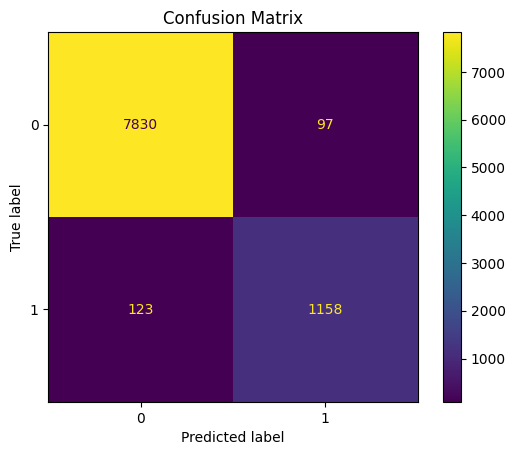

In [37]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()
plt.title("Confusion Matrix")
plt.savefig("./test_confusion_matrix.png");

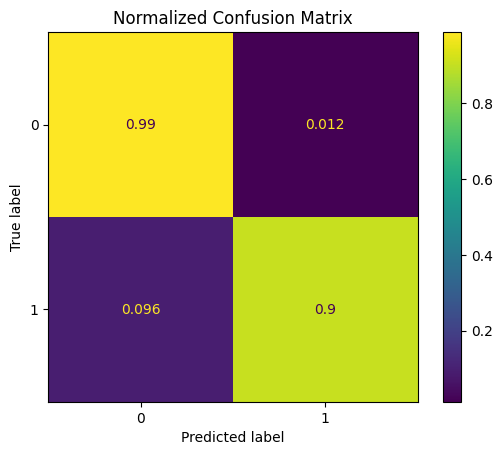

In [38]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)

# plot the normalized confusion matrix
cm_display.plot()
plt.title("Normalized Confusion Matrix")
plt.savefig("./test_normalized_confusion_matrix.png");

In [40]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image


def inference(img_dir):
  # preprocess the image
  img = Image.open(img_dir)
  img = img.resize((299, 299))
  img = img.convert("RGB")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  # predict the image
  predict_coef = model.predict(img)
  disease_type = ["COVID" if predict_coef >= 0.5 else "Non-COVID"]

  return disease_type